In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


drive_mount = False
if drive_mount:
    from google.colab import drive
    drive.mount('/content/drive/')
    DATA_DIR = "/content/drive/MyDrive/Colab_Notebooks/COMP0036/datasets"
    MODEL_DIR = "/content/drive/MyDrive/Colab_Notebooks/COMP0036/models"
else:
    DATA_DIR = "../processed_df"
    MODEL_DIR = "../models"
EPL_TRAINING_DATA_CSV = DATA_DIR + "/epl-with-elo-season.csv"
EPL_ORIGINAL_DATA_CSV = "..datasets/epl-training.csv"
EPL_TEST_DATA_CSV = DATA_DIR + "/sample-submission.csv"

def df_save(df, dropna=False):
    if dropna:
        df = df.dropna()
    df.to_csv(f'../processed_df/history.csv', index=False)


# Read the CSV file
epl_training_df = pd.read_csv(EPL_TRAINING_DATA_CSV)

epl_training_df['Date'] = pd.to_datetime(epl_training_df['Date'], format='mixed', dayfirst=True)
epl_training_df


,Date,HomeTeam,AwayTeam,FTR,HTR,Referee,HomeTeamExpenditure,HomeTeamIncome,HomeTeamBalance,AwayTeamExpenditure,...,Pts_Home,Team_Away,Rk_Away,W_Away,D_Away,L_Away,GF_Away,GA_Away,GD_Away,Pts_Away
0,2000-08-19,Charlton,Man City,H,H,Rob Harris,20.80,0.532,-20.27,20.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,Chelsea,West Ham,H,H,Graham Barber,52.39,37.720,-14.67,18.65,...,65.0,West Ham,9.0,15.0,10.0,13.0,52.0,53.0,-1.0,55.0
2,2000-08-19,Coventry,Middlesbrough,A,D,Barry Knight,19.00,26.280,7.28,33.47,...,44.0,Middlesbrough,12.0,14.0,10.0,14.0,46.0,52.0,-6.0,52.0
3,2000-08-19,Derby,Southampton,D,A,Andy D'Urso,13.33,6.880,-6.45,0.00,...,38.0,Southampton,15.0,12.0,8.0,18.0,45.0,62.0,-17.0,44.0
4,2000-08-19,Leeds,Everton,H,H,Dermot Gallagher,53.15,12.330,-40.82,34.48,...,69.0,Everton,13.0,12.0,14.0,12.0,59.0,49.0,10.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8835,2023-10-29,West Ham,Everton,A,D,S Attwell,137.56,156.400,18.84,40.50,...,40.0,Everton,17.0,8.0,12.0,18.0,34.0,57.0,-23.0,36.0
8836,2023-10-29,Aston Villa,Luton,H,H,J Brooks,93.00,32.550,-60.45,22.75,...,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8837,2023-10-29,Brighton,Fulham,D,H,M Salisbury,100.35,195.900,95.55,68.47,...,62.0,Fulham,10.0,15.0,7.0,16.0,55.0,53.0,2.0,52.0
8838,2023-10-29,Liverpool,Nott'm Forest,H,H,C Salisbury,172.00,60.700,-111.30,122.05,...,67.0,Nott'm Forest,16.0,9.0,11.0,18.0,38.0,68.0,-30.0,38.0


In [5]:
last_match_time = {}


def calculate_time_difference(row):
    home_team = row["HomeTeam"]
    away_team = row["AwayTeam"]

    home_rest_time = 0
    away_rest_time = 0

    # Check if the teams have played a match before
    if home_team in last_match_time:
        last_time = last_match_time[home_team]
        time_diff = row["Date"] - last_time
        home_rest_time = time_diff.days
        last_match_time[home_team] = row["Date"]
    else:
        last_match_time[home_team] = row["Date"]

    if away_team in last_match_time:
        last_time = last_match_time[away_team]
        time_diff = row["Date"] - last_time
        away_rest_time = time_diff.days
        last_match_time[away_team] = row["Date"]
    else:
        last_match_time[away_team] = row["Date"]

    return pd.Series([home_rest_time, away_rest_time])


# Apply the function and store the result in a temporary DataFrame
result = epl_training_df.apply(calculate_time_difference, axis=1)

# Rename the columns of the result DataFrame
result.columns = ["home_rest_time", "away_rest_time"]

# Concatenate the original DataFrame and the result DataFrame
epl_training_df = pd.concat([epl_training_df, result], axis=1)

epl_training_df

,Date,HomeTeam,AwayTeam,FTR,HTR,Referee,HomeTeamExpenditure,HomeTeamIncome,HomeTeamBalance,AwayTeamExpenditure,...,Rk_Away,W_Away,D_Away,L_Away,GF_Away,GA_Away,GD_Away,Pts_Away,home_rest_time,away_rest_time
0,2000-08-19,Charlton,Man City,H,H,Rob Harris,20.80,0.532,-20.27,20.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2000-08-19,Chelsea,West Ham,H,H,Graham Barber,52.39,37.720,-14.67,18.65,...,9.0,15.0,10.0,13.0,52.0,53.0,-1.0,55.0,0,0
2,2000-08-19,Coventry,Middlesbrough,A,D,Barry Knight,19.00,26.280,7.28,33.47,...,12.0,14.0,10.0,14.0,46.0,52.0,-6.0,52.0,0,0
3,2000-08-19,Derby,Southampton,D,A,Andy D'Urso,13.33,6.880,-6.45,0.00,...,15.0,12.0,8.0,18.0,45.0,62.0,-17.0,44.0,0,0
4,2000-08-19,Leeds,Everton,H,H,Dermot Gallagher,53.15,12.330,-40.82,34.48,...,13.0,12.0,14.0,12.0,59.0,49.0,10.0,50.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8835,2023-10-29,West Ham,Everton,A,D,S Attwell,137.56,156.400,18.84,40.50,...,17.0,8.0,12.0,18.0,34.0,57.0,-23.0,36.0,7,8
8836,2023-10-29,Aston Villa,Luton,H,H,J Brooks,93.00,32.550,-60.45,22.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8
8837,2023-10-29,Brighton,Fulham,D,H,M Salisbury,100.35,195.900,95.55,68.47,...,10.0,15.0,7.0,16.0,55.0,53.0,2.0,52.0,8,6
8838,2023-10-29,Liverpool,Nott'm Forest,H,H,C Salisbury,172.00,60.700,-111.30,122.05,...,16.0,9.0,11.0,18.0,38.0,68.0,-30.0,38.0,8,8


In [3]:
def calculate_rolling_averages(df, n=5, n_same_team=2):
    # Columns to exclude
    exclude_columns = [
        "HTR",
        "FTR",
        "Date",
        "HomeTeam",
        "AwayTeam",
        "Referee",
    ]

    # Columns to calculate rolling averages for
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    columns_to_calculate = [
        col for col in numeric_columns if col not in exclude_columns
    ]

    # Sort the DataFrame by Date
    df = df.sort_values(by="Date")

    # Calculate rolling mean for the last n matches for each team
    for col in columns_to_calculate:
        home_col_name = f"Home{col}_all_avg_{n}"
        away_col_name = f"Away{col}_all_avg_{n}"

        df[home_col_name] = df.groupby("HomeTeam")[col].transform(
            lambda x: x.rolling(window=n, min_periods=n).mean().shift()
        )
        df[away_col_name] = df.groupby("AwayTeam")[col].transform(
            lambda x: x.rolling(window=n, min_periods=n).mean().shift()
        )

    for col in columns_to_calculate:
        home_col_name = f"Home{col}_same_avg_{n_same_team}"
        away_col_name = f"Away{col}_same_avg_{n_same_team}"
        if col in ["FTHG", "HTHG", "HS", "HST", "HC", "HF", "HY", "HR"]:
            df[home_col_name] = df.groupby(["HomeTeam", "AwayTeam"])[col].transform(
                lambda x: x.rolling(window=n_same_team, min_periods=n_same_team)
                .mean()
                .shift()
            )
        else:
            df[away_col_name] = df.groupby(["AwayTeam", "HomeTeam"])[col].transform(
                lambda x: x.rolling(window=n_same_team, min_periods=n_same_team)
                .mean()
                .shift()
            )

    return df


# Update the DataFrame
N = 25
N_same_team = 2
df = calculate_rolling_averages(epl_training_df, n=N, n_same_team=N_same_team)
del_columns = [
    "FTHG",
    "FTAG",
    "HTHG",
    "HTAG",
    "HTR",
    "Referee",
    "HS",
    "AS",
    "HST",
    "AST",
    "HC",
    "AC",
    "HF",
    "AF",
    "HY",
    "AY",
    "HR",
    "AR",
]
# df = df.drop(del_columns, axis=1)

df

/var/folders/tp/5_2qd5b557jdxkkm150cbnl80000gn/T/ipykernel_6531/98642153.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[away_col_name] = df.groupby(["AwayTeam", "HomeTeam"])[col].transform(
/var/folders/tp/5_2qd5b557jdxkkm150cbnl80000gn/T/ipykernel_6531/98642153.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[away_col_name] = df.groupby(["AwayTeam", "HomeTeam"])[col].transform(
/var/folders/tp/5_2qd5b557jdxkkm150cbnl80000gn/T/ipykernel_6531/98642153.py:43: PerformanceWarning: DataFrame is highly fragmented.  Thi

,Date,HomeTeam,AwayTeam,FTR,HTR,Referee,HomeTeamExpenditure,HomeTeamIncome,HomeTeamBalance,AwayTeamExpenditure,...,AwayRk_Away_same_avg_2,AwayW_Away_same_avg_2,AwayD_Away_same_avg_2,AwayL_Away_same_avg_2,AwayGF_Away_same_avg_2,AwayGA_Away_same_avg_2,AwayGD_Away_same_avg_2,AwayPts_Away_same_avg_2,Awayhome_rest_time_same_avg_2,Awayaway_rest_time_same_avg_2
0,2000-08-19,Charlton,Man City,H,H,Rob Harris,20.80,0.532,-20.27,20.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,Chelsea,West Ham,H,H,Graham Barber,52.39,37.720,-14.67,18.65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-08-19,Coventry,Middlesbrough,A,D,Barry Knight,19.00,26.280,7.28,33.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-08-19,Derby,Southampton,D,A,Andy D'Urso,13.33,6.880,-6.45,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-08-19,Leeds,Everton,H,H,Dermot Gallagher,53.15,12.330,-40.82,34.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8837,2023-10-29,Brighton,Fulham,D,H,M Salisbury,100.35,195.900,95.55,68.47,...,14.0,10.0,10.0,18.0,41.0,53.0,-12.0,40.0,9.0,7.0
8838,2023-10-29,Liverpool,Nott'm Forest,H,H,C Salisbury,172.00,60.700,-111.30,122.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8835,2023-10-29,West Ham,Everton,A,D,S Attwell,137.56,156.400,18.84,40.50,...,16.5,9.5,9.0,19.5,38.5,61.5,-23.0,37.5,10.5,12.0
8836,2023-10-29,Aston Villa,Luton,H,H,J Brooks,93.00,32.550,-60.45,22.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_save(df)

In [50]:
import pandas as pd

def add_win_loss_streaks(df):
    # Initialize columns
    df['HomeWinStreak'] = 0
    df['HomeLossStreak'] = 0
    df['AwayWinStreak'] = 0
    df['AwayLossStreak'] = 0

    # Create mappings for results
    home_result_mapping = {'H': 'W', 'A': 'L', 'D': 'D'}
    away_result_mapping = {'H': 'L', 'A': 'W', 'D': 'D'}

    # Track streaks for each team
    streaks = {team: {'win': 0, 'loss': 0} for team in pd.concat([df['HomeTeam'], df['AwayTeam']]).unique()}

    # Iterate over rows to calculate the streaks
    for index, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']

        # Assign the calculated streaks to the DataFrame
        df.at[index, 'HomeWinStreak'] = streaks[home_team]['win']
        df.at[index, 'HomeLossStreak'] = streaks[home_team]['loss']
        df.at[index, 'AwayWinStreak'] = streaks[away_team]['win']
        df.at[index, 'AwayLossStreak'] = streaks[away_team]['loss']

        # Update streaks based on the current row's result
        home_result = home_result_mapping[row['FTR']]
        away_result = away_result_mapping[row['FTR']]

        if home_result == 'W':
            streaks[home_team]['win'] += 1
            streaks[home_team]['loss'] = 0
        elif home_result == 'L':
            streaks[home_team]['win'] = 0
            streaks[home_team]['loss'] += 1
        else:
            streaks[home_team]['win'] = 0
            streaks[home_team]['loss'] = 0

        if away_result == 'W':
            streaks[away_team]['win'] += 1
            streaks[away_team]['loss'] = 0
        elif away_result == 'L':
            streaks[away_team]['win'] = 0
            streaks[away_team]['loss'] += 1
        else:
            streaks[away_team]['win'] = 0
            streaks[away_team]['loss'] = 0

    return df

# Example usage:
# df = pd.read_csv('your_data.csv')
df = add_win_loss_streaks(df)
df

,Date,HomeTeam,AwayTeam,FTR,HomeFTHG_avg_25,AwayFTHG_avg_25,HomeFTAG_avg_25,AwayFTAG_avg_25,HomeHTHG_avg_25,AwayHTHG_avg_25,...,HomeAY_avg_25,AwayAY_avg_25,HomeHR_avg_25,AwayHR_avg_25,HomeAR_avg_25,AwayAR_avg_25,HomeWinStreak,HomeLossStreak,AwayWinStreak,AwayLossStreak
0,2000-08-19,Charlton,Man City,H,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2000-08-19,Chelsea,West Ham,H,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2000-08-19,Coventry,Middlesbrough,A,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,2000-08-19,Derby,Southampton,D,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,2000-08-19,Leeds,Everton,H,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8838,2023-10-29,Brighton,Fulham,D,2.12,1.36,1.20,1.16,0.84,0.56,...,2.72,2.68,0.00,0.12,0.00,0.04,0,1,0,1
8839,2023-10-29,Liverpool,Nott'm Forest,H,2.44,NaN,0.84,NaN,1.08,NaN,...,1.84,NaN,0.08,NaN,0.04,NaN,1,0,0,0
8836,2023-10-29,West Ham,Everton,A,1.48,1.76,1.36,0.96,0.88,0.88,...,1.56,2.16,0.04,0.00,0.00,0.08,0,1,0,1
8837,2023-10-29,Aston Villa,Luton,H,2.08,NaN,1.04,NaN,1.00,NaN,...,2.12,NaN,0.00,NaN,0.08,NaN,1,0,0,0


In [51]:
df_save(df)

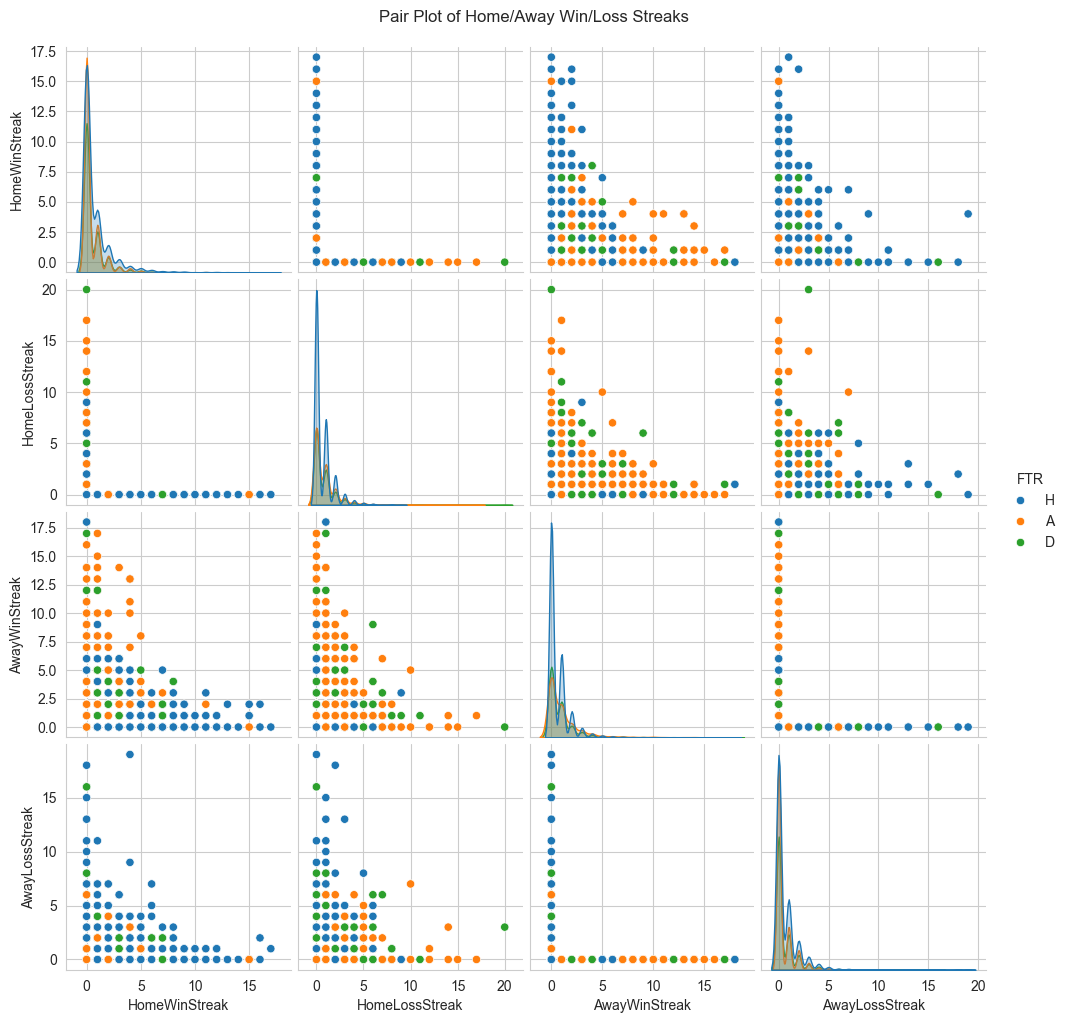

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the calculated HomeWinStreak, HomeLossStreak, AwayWinStreak, AwayLossStreak, and FTR columns

# Create a pair plot
pair_plot = sns.pairplot(data=df, vars=['HomeWinStreak', 'HomeLossStreak', 'AwayWinStreak', 'AwayLossStreak'], hue='FTR', kind='scatter')
pair_plot.fig.suptitle('Pair Plot of Home/Away Win/Loss Streaks', y=1.02)
plt.show()
